In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Part 1: SIFT computation for one single image

In [8]:
# Load image and compute SIFT
img = cv2.imread('image_0003.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp, desc = sift.detectAndCompute(gray, None)

print(f'{len(kp)} key points detected.')
print(f'Size of descriptors matrix: {desc.shape}')

363 key points detected.
Size of descriptors matrix: (363, 128)


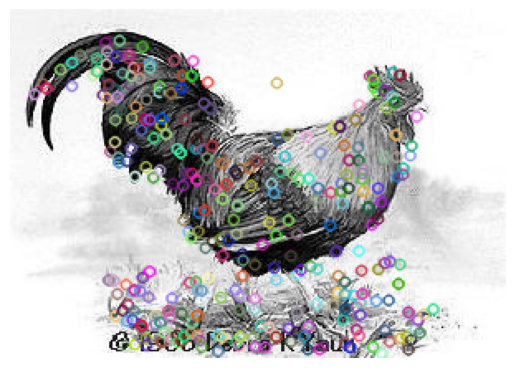

In [12]:
# Draw keypoints in image and show it
A = np.array(cv2.drawKeypoints(gray, kp, img))

plt.imshow(A)
plt.axis('off')
plt.show()

# Part 2: SIFT computation for a set of images

In [82]:
# Define a base directory
BASEPATH = 'Caltech_101'

In [83]:
# Count the number of images in each class of the Caltech101 dataset
import os

class_names = os.listdir(BASEPATH)
class_names.sort()
class_freqs = np.array([len(os.listdir(os.path.join(BASEPATH, class_id))) for class_id in class_names])

print(f"{len(class_names)} classes found.")
print(class_names)
print(class_freqs)

102 classes found.
['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_h

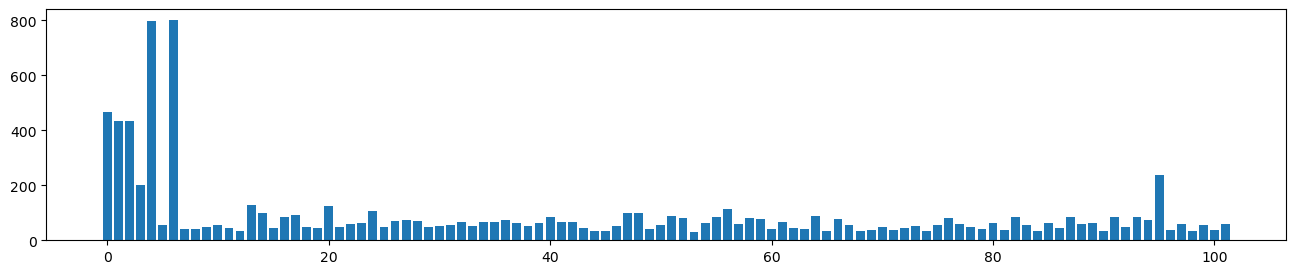

In [84]:
# Plot a histogram
plt.figure(figsize=(16, 3))
plt.bar(range(len(class_freqs)), class_freqs)
plt.show()

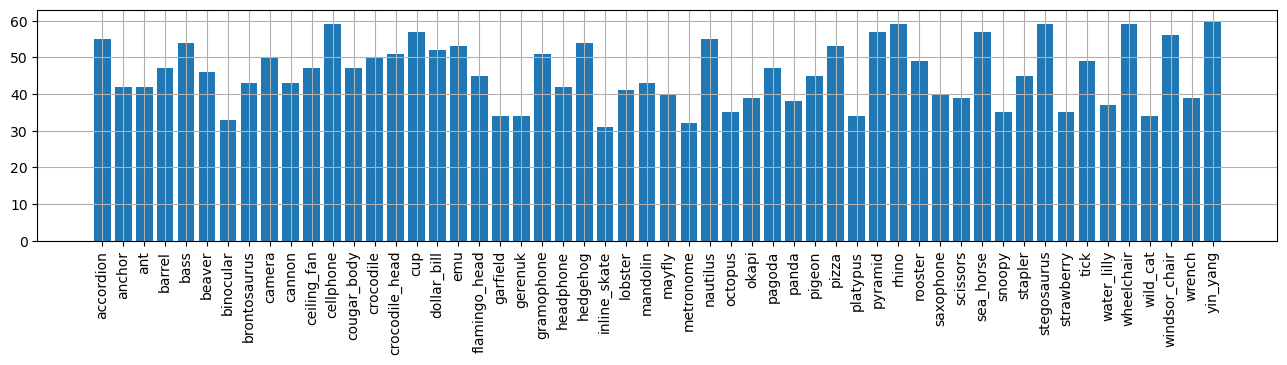

In [85]:
# Remove classes with more than 60 instances
from itertools import compress
to_Keep = class_freqs <= 60
class_names = list(compress(class_names, to_Keep))
class_freqs = class_freqs[to_Keep]

plt.figure(figsize=(16, 3))
plt.bar(range(len(class_freqs)), class_freqs)
plt.xticks(range(len(class_freqs)), class_names, rotation='vertical')
plt.grid()
plt.show()

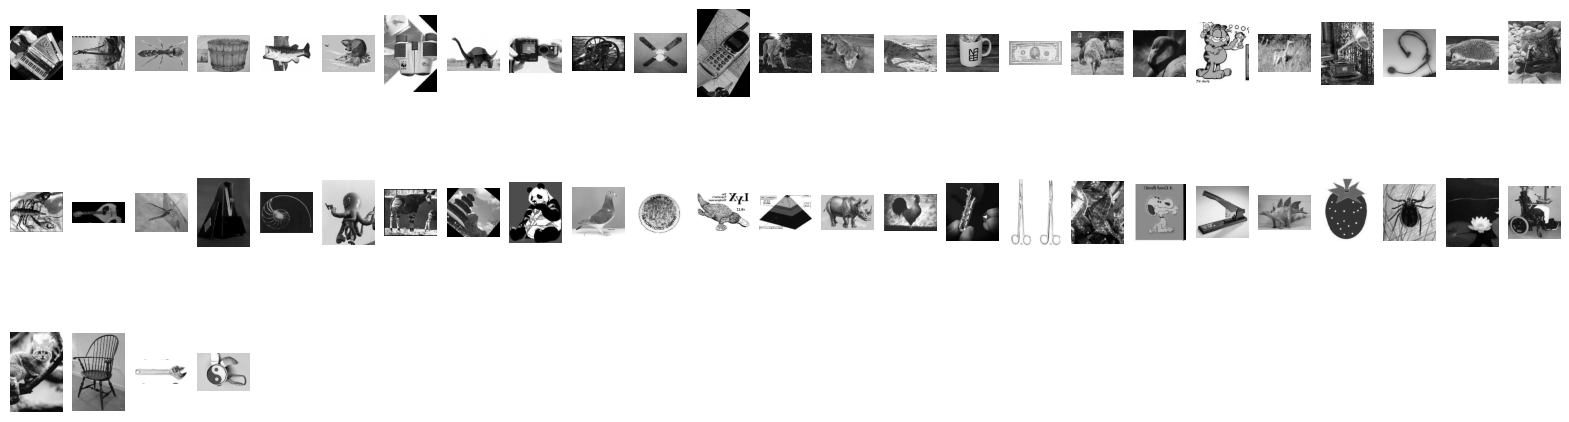

In [86]:
# Show one example per class
plt.figure(figsize=(20, 10))
for it_class, class_id in enumerate(class_names):
    class_files = os.listdir(os.path.join(BASEPATH, class_id))
    img = cv2.imread(os.path.join(BASEPATH, class_id, class_files[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.subplot(5, 25, it_class+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [87]:
# Get the full path for all files
all_files_names = []
all_files_classes = []
for it_class, class_id in enumerate(class_names):
    class_files = os.listdir(os.path.join(BASEPATH, class_id))
    for file_name in class_files:
        all_files_names.append(os.path.join(BASEPATH, class_id, file_name))
        all_files_classes.append(it_class)
all_files_classes = np.array(all_files_classes)

In [88]:
# Split training and test sets
from sklearn.model_selection import train_test_split
names_train, names_test, y_train, y_test = train_test_split(all_files_names, all_files_classes, test_size=0.2)

In [116]:
file_path = names_train[0]
img = cv2.imread(file_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
_, desc = sift.detectAndCompute(gray, None)
desc = np.clip(normalize(desc), 0.0, 0.2)
desc = normalize(desc)

In [122]:
# Define a function that loads an image and computes its SIFT descriptors
from sklearn.preprocessing import normalize

def compute_SIFT(file_path):
    img = cv2.imread(file_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    _, desc = sift.detectAndCompute(gray, None)
    desc = np.clip(normalize(desc), 0.0, 0.2)
    return(normalize(desc))

In [123]:
# Compute up to 50,000 SIFT descriptors from training images to use them for dictionary training
from random import sample

train_SIFTS = []
for file_name in sample(names_train, len(names_train)): # Use random subset of training samples
    train_SIFTS.extend(compute_SIFT(file_name))
    if len(train_SIFTS) >= 50_000:
        break
        
train_SIFTS = np.array(train_SIFTS)

Inertia: 10747.5185546875


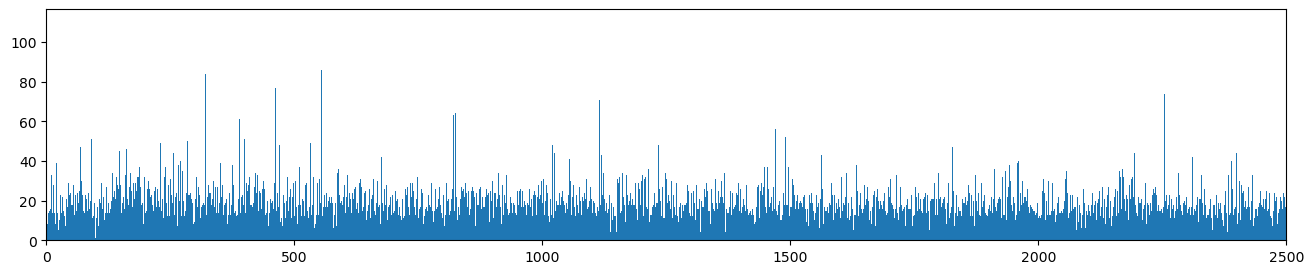

In [124]:
# Train a visual dictionary
from sklearn.cluster import KMeans

num_clusters = 2500
kmeans = KMeans(n_clusters=num_clusters, n_init=10).fit(train_SIFTS)
print(f"Inertia: {kmeans.inertia_}")

# Show frequency distribution of words
plt.figure(figsize=(16, 3))
plt.hist(kmeans.labels_, num_clusters)
plt.xlim(0, num_clusters)
plt.show()

In [125]:
# Read an image, estimate its SIFT descriptors and BoW representation
def get_visual_words(file_path):
    SIFTS = compute_SIFT(file_path)
    v_words = kmeans.predict(SIFTS)
    return(v_words)

In [126]:
# Compute the BOW representation for all the training set
BOW_train = np.zeros((len(names_train), num_clusters))
bins = np.arange(0, num_clusters+1)
for it_file, file_name in enumerate(names_train):
    v_words = get_visual_words(file_name)
    BOW_train[it_file], _ = np.histogram(v_words, bins, density=True)

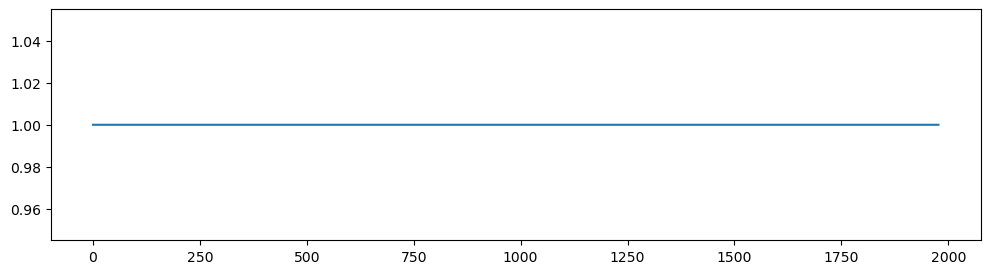

(1978, 2500)
(1978,)


In [127]:
# Show all BOW representations sum up to one
plt.figure(figsize=(12, 3))
plt.plot(BOW_train.sum(axis=1))
plt.show()

print(BOW_train.shape)
print(y_train.shape)

In [128]:
# Compute the BOW representation for all the test set
BOW_test = np.zeros((len(names_test), num_clusters))
bins = np.arange(0, num_clusters+1)
for it_file, file_name in enumerate(names_test):
    v_words = get_visual_words(file_name)
    BOW_test[it_file], _ = np.histogram(v_words, bins, density=True)

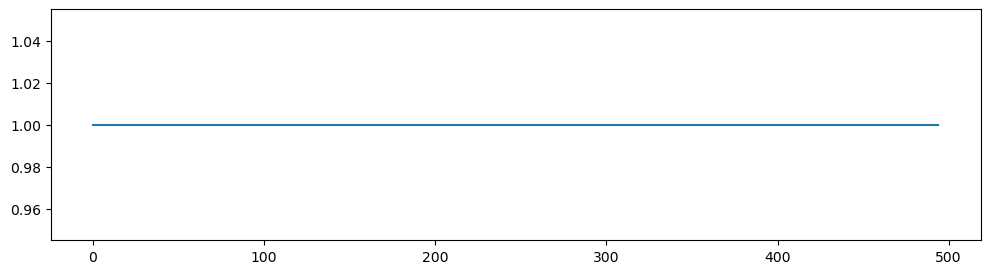

(495, 2500)
(495,)


In [129]:
# Show all BOW representations sum up to one
plt.figure(figsize=(12, 3))
plt.plot(BOW_test.sum(axis=1))
plt.show()

print(BOW_test.shape)
print(y_test.shape)

In [97]:
# At this point, each image is described by a BoW representation of local SIFT descriptors

# Part 3: Use the BoW's of SIFT descriptors for classification

In [130]:
# Imports for training a linear SVC with grid search
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [69]:
# Define grid search parameters
hyperparams = {'kernel': ['linear', 'poly', 'rbf'],
               'C': [0.01, 0.1, 1.0, 10, 100],
               'degree': [1, 2, 3, 4],
               'gamma': ['auto', 'scale'],
               'coef0': [1/4, 1/2, 1, 2]}
hyperparams

{'kernel': ['linear', 'poly', 'rbf'],
 'C': [0.01, 0.1, 1.0, 10, 100],
 'degree': [1, 2, 3, 4],
 'gamma': ['auto', 'scale'],
 'coef0': [0.25, 0.5, 1, 2]}

In [72]:
# Create and train the classifiers with grid search
gs = GridSearchCV(SVC(), hyperparams, verbose=True, n_jobs=-1)
gs.fit(BOW_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100],
                         'coef0': [0.25, 0.5, 1, 2], 'degree': [1, 2, 3, 4],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=True)

In [73]:
# Print info about best score and best hyperparameters
print(f"Best score: {gs.best_score_:.3f}")
print(f"Best params: {gs.best_params_}")

Best score: 0.284
Best params: {'C': 10, 'coef0': 0.25, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [75]:
# Evaluate on the test set
best_svm = gs.best_estimator_

print(f"Train mean accuracy: {best_svm.score(BOW_train, y_train):.3f}")
print(f"Test mean accuracy: {best_svm.score(BOW_test, y_test):.3f}")

Train mean accuracy: 1.000
Test mean accuracy: 0.268


In [ ]:
#Tree

In [81]:
hyperparams = {'n_estimators': range(1, 31),
              'criterion': ['gini', 'entropy'],
              'max_depth': range(1, 11),
              'min_samples_split': range(2, 6),
              'min_samples_leaf': range(1, 6),
              'max_features': [None, 'sqrt', 'log2']}

gs_model = GridSearchCV(RandomForestClassifier(), hyperparams, verbose=True, n_jobs=-1)
gs_model.fit(BOW_train, y_train)

Fitting 5 folds for each of 36000 candidates, totalling 180000 fits


KeyboardInterrupt: 

In [ ]:
# Print info about best score and best hyperparameters
print(f"Best score: {gs_model.best_score_:.3f}")
print(f"Best params: {gs_model.best_params_}")

In [79]:
# Evaluate on the test set
best_classifier = gs_model.best_estimator_

print(f"Train mean accuracy: {best_classifier.score(BOW_train, y_train):.3f}")
print(f"Test mean accuracy: {best_classifier.score(BOW_test, y_test):.3f}")

Train mean accuracy: 0.127
Test mean accuracy: 0.062


In [131]:
# Gradient Boosting

In [132]:
# Define grid search parameters
hyperparams = {'learning_rate': [0.001, 0.01, 0.1, 1.0],
               'n_estimators': [2, 5, 10, 20, 30],
               'max_depth': range(2, 11),
               'min_samples_split': range(2, 7, 2),
               'min_samples_leaf': range(1, 6, 2),
               'max_features': [None, 'sqrt', 'log2']}
hyperparams

{'learning_rate': [0.001, 0.01, 0.1, 1.0],
 'n_estimators': [2, 5, 10, 20, 30],
 'max_depth': range(2, 11),
 'min_samples_split': range(2, 7, 2),
 'min_samples_leaf': range(1, 6, 2),
 'max_features': [None, 'sqrt', 'log2']}

In [ ]:
# Create and train the classifiers with grid search
gs_model = GridSearchCV(GradientBoostingClassifier(), hyperparams, verbose=True, n_jobs=-1)
gs_model.fit(BOW_train, y_train)

Fitting 5 folds for each of 4860 candidates, totalling 24300 fits


In [ ]:
# Print info about best score and best hyperparameters
print(f"Best score: {gs_model.best_score_:.3f}")
print(f"Best params: {gs_model.best_params_}")

In [ ]:
# Evaluate on the test set
best_classifier = gs_model.best_estimator_

print(f"Train mean accuracy: {best_classifier.score(BOW_train, y_train):.3f}")
print(f"Test mean accuracy: {best_classifier.score(BOW_test, y_test):.3f}")

In [ ]:
# Train a linear SVM
from sklearn.svm import SVC
CS = [0.003, 0.009, 0.03, 0.09, 0.3, 0.9, 3, 9, 30, 90, 300, 900, 3000, 9000, 30000, 90000]
for it_c, c in enumerate(CS):
    svm = SVC(kernel='linear', C=c, random_state=0)
    svm.fit(BOW_train, y_train)
    y_train_pred = svm.predict(BOW_train)
    err_train = (y_train_pred != y_train).sum() / len(y_train)
    y_val_pred = svm.predict(BOW_val)
    err_val = (y_val_pred != y_val).sum() / len(y_val)
    print(f"C: {c}   \t --  Error, train: {err_train:6.4f}, val: {err_val:6.4f}")

C: 0.003   	 --  Error, train: 0.9789, val: 0.9862
C: 0.009   	 --  Error, train: 0.9789, val: 0.9862
C: 0.03   	 --  Error, train: 0.9789, val: 0.9862
C: 0.09   	 --  Error, train: 0.9789, val: 0.9862
C: 0.3   	 --  Error, train: 0.9789, val: 0.9862
C: 0.9   	 --  Error, train: 0.9789, val: 0.9862
C: 3   	 --  Error, train: 0.9777, val: 0.9862
C: 9   	 --  Error, train: 0.9575, val: 0.9736
C: 30   	 --  Error, train: 0.8821, val: 0.9434
C: 90   	 --  Error, train: 0.5918, val: 0.8327
C: 300   	 --  Error, train: 0.1434, val: 0.7258
C: 900   	 --  Error, train: 0.0060, val: 0.6881
C: 3000   	 --  Error, train: 0.0000, val: 0.6881
C: 9000   	 --  Error, train: 0.0000, val: 0.6881
C: 30000   	 --  Error, train: 0.0000, val: 0.6881
C: 90000   	 --  Error, train: 0.0000, val: 0.6881


In [ ]:
# Train a RBF SVM
GAMMAS = [0.003, 0.009, 0.03, 0.09, 0.3, 0.9, 3, 9, 30, 90, 300, 900, 3000, 9000, 30000, 90000]
CS = [0.003, 0.009, 0.03, 0.09, 0.3, 0.9, 3, 9, 30, 90, 300, 900, 3000, 9000, 30000, 90000]
err_train = np.zeros((len(CS), len(GAMMAS)))
err_val = np.zeros((len(CS), len(GAMMAS)))
for it_gamma, gamma in enumerate(GAMMAS):
    for it_c, c in enumerate(CS):
        svm = SVC(kernel='rbf', gamma=gamma, C=c)
        svm.fit(BOW_train, y_train)
        y_train_pred = svm.predict(BOW_train)
        err_train[it_c, it_gamma] = (y_train_pred != y_train).sum() / len(y_train)
        y_val_pred = svm.predict(BOW_val)
        err_val[it_c, it_gamma] = (y_val_pred != y_val).sum() / len(y_val)
        print(f"C: {c} , Gamma: {gamma} -- Error, train: {err_train[it_c, it_gamma]:6.4f}, val: {err_val[it_c, it_gamma]:6.4f}")

C: 0.003 , Gamma: 0.003 -- Error, train: 0.9789, val: 0.9862
C: 0.009 , Gamma: 0.003 -- Error, train: 0.9789, val: 0.9862
C: 0.03 , Gamma: 0.003 -- Error, train: 0.9789, val: 0.9862
C: 0.09 , Gamma: 0.003 -- Error, train: 0.9789, val: 0.9862
C: 0.3 , Gamma: 0.003 -- Error, train: 0.9789, val: 0.9862
C: 0.9 , Gamma: 0.003 -- Error, train: 0.9789, val: 0.9862
C: 3 , Gamma: 0.003 -- Error, train: 0.9789, val: 0.9862
C: 9 , Gamma: 0.003 -- Error, train: 0.9789, val: 0.9862
C: 30 , Gamma: 0.003 -- Error, train: 0.9789, val: 0.9862
C: 90 , Gamma: 0.003 -- Error, train: 0.9789, val: 0.9862
C: 300 , Gamma: 0.003 -- Error, train: 0.9789, val: 0.9862
C: 900 , Gamma: 0.003 -- Error, train: 0.9695, val: 0.9824
C: 3000 , Gamma: 0.003 -- Error, train: 0.9280, val: 0.9572
C: 9000 , Gamma: 0.003 -- Error, train: 0.7516, val: 0.8906
C: 30000 , Gamma: 0.003 -- Error, train: 0.3157, val: 0.7522
C: 90000 , Gamma: 0.003 -- Error, train: 0.0277, val: 0.7031
C: 0.003 , Gamma: 0.009 -- Error, train: 0.9789, v

In [ ]:
# Save results
np.savetxt("2500_Err_tr.csv", err_train, delimiter=",")
np.savetxt("2500_Err_va.csv", err_val, delimiter=",")

In [ ]:
svm = SVC(kernel='poly', gamma=90, C=9)
svm.fit(BOW_train, y_train)
y_train_pred = svm.predict(BOW_train)
err_t = (y_train_pred != y_train).sum() / len(y_train)
y_val_pred = svm.predict(BOW_val)
err_v = (y_val_pred != y_val).sum() / len(y_val)
print(f"Error, train: {err_t:6.4f}, val: {err_v:6.4f}")

Error, train: 0.1063, val: 0.7673


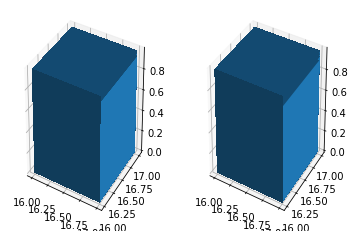

In [ ]:
# Plot in 3D
from mpl_toolkits.mplot3d import Axes3D
_xx, _yy = np.meshgrid(len(CS), len(GAMMAS))
x, y = _xx.ravel(), _yy.ravel()
width = depth =  1

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax1.bar3d(x, y, np.zeros_like(err_train.ravel()), width, depth, err_train.ravel(), shade=True)
ax2 = fig.add_subplot(122, projection='3d')
ax2.bar3d(x, y, np.zeros_like(err_val.ravel()), width, depth, err_val.ravel(), shade=True)
plt.show()

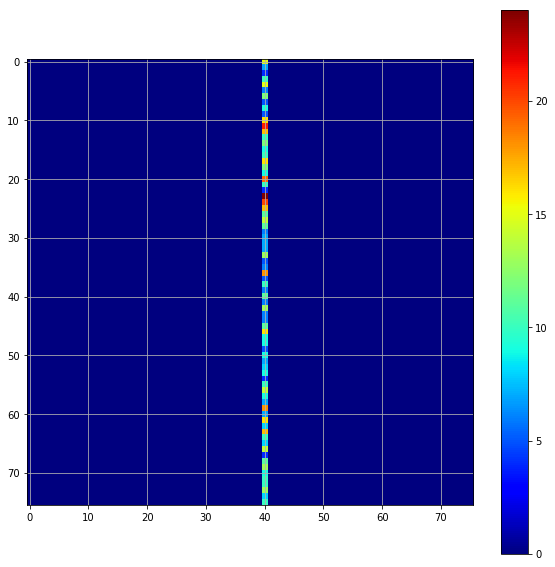

In [ ]:
#
from sklearn.metrics import confusion_matrix

Conf_Mat = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 10))
plt.imshow(Conf_Mat, cmap='jet')
plt.grid()
plt.colorbar()
plt.show()

In [ ]:
whos

Variable            Type                Data/Info
-------------------------------------------------
A                   ndarray             225x300x3: 202500 elems, type `uint8`, 202500 bytes (197.75390625 kb)
Axes3D              type                <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>
BASEPATH            str                 /home/eromanr/Downloads/101_ObjectCategories/
BOW_train           ndarray             3180x500: 1590000 elems, type `float64`, 12720000 bytes (12.1307373046875 Mb)
BOW_val             ndarray             795x500: 397500 elems, type `float64`, 3180000 bytes (3.032684326171875 Mb)
CS                  list                n=16
Conf_Mat            ndarray             76x76: 5776 elems, type `int64`, 46208 bytes
GAMMAS              list                n=16
KMeans              type                <class 'sklearn.cluster.k_means_.KMeans'>
SVC                 ABCMeta             <class 'sklearn.svm.classes.SVC'>
all_files_classes   ndarray             3975: 3975 ele